In [2]:
# Data set structured as follows:
# CSV File with two columns
# Column 1: Email
# Column 2: Spam or Ham (1 = spam, 0 = ham)
# This is a naive bayes models

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter

from sklearn.preprocessing import LabelEncoder
# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laila_tantavy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laila_tantavy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# importing training data set
data = pd.read_csv("emails_training.csv")
data.sample(5)

,text,spam
4884,Subject: re : corporate allocation from enron ...,0
564,Subject: your commissions of $ 5000 per week !...,1
2643,"Subject: bill koures vince , alex and i did ...",0
1879,Subject: ibuyit form attached please find the...,0
828,Subject: re : [ 3 ] this will be our closing ...,1


In [7]:
# Data exploration
data.rename(columns={'text':'email'}, inplace=True)
data.head(5)

,email,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


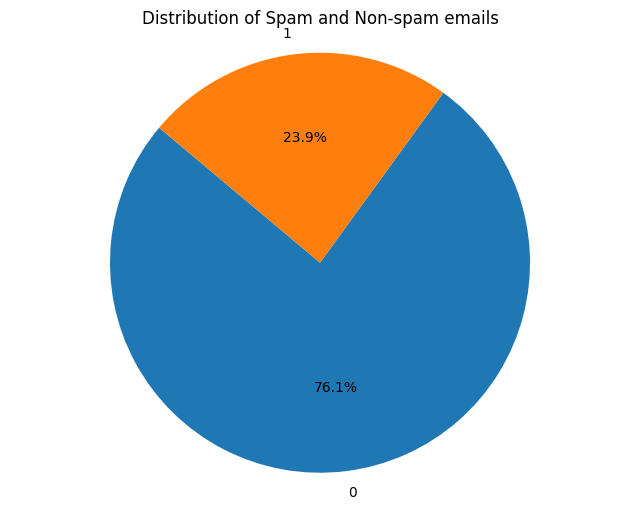

In [8]:
data['spam'].value_counts()
# Plotting
plt.figure(figsize=(8,6))
plt.pie(data['spam'].value_counts(), labels=data['spam'].value_counts().index, autopct="%1.1f%%",startangle=140)
plt.title('Distribution of Spam and Non-spam emails')
plt.axis('equal')
plt.show()

In [9]:
# Email stats
data['Length'] = data['email'].apply(len)
data['num_words'] = data['email'].apply(word_tokenize).apply(len)
data['num_sentences'] = data['email'].apply(sent_tokenize).apply(len)
data.head(2)

,email,spam,Length,num_words,num_sentences
0,Subject: naturally irresistible your corporate...,1,1484,325,11
1,Subject: the stock trading gunslinger fanny i...,1,598,90,1


Average Length of Spam Emails:  1317.2573099415204
Average Length of Ham Emails:  1631.918119266055


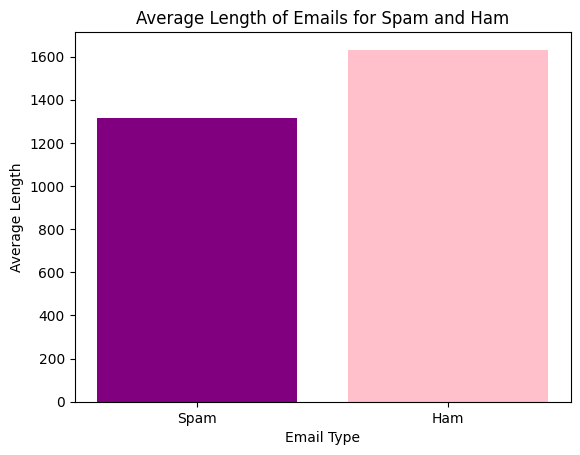

In [10]:
avg_length_spam = data[data['spam'] == 1]['Length'].mean()
avg_length_ham = data[data['spam'] == 0]['Length'].mean()
# plotting
print("Average Length of Spam Emails: ", avg_length_spam)
print("Average Length of Ham Emails: ", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Purple', 'Pink'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Words in a Spam Email:  267.89619883040933
Average Words in a Ham Email:  346.83532110091744


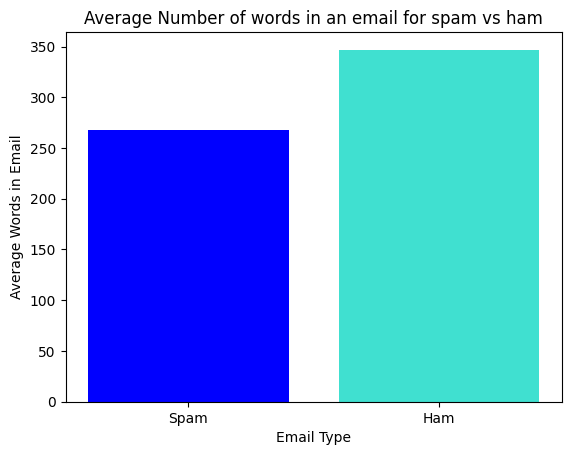

In [11]:
# average words
avg_word_spam = data[data['spam'] == 1]['num_words'].mean()
avg_word_ham = data[data['spam'] == 0]['num_words'].mean()
print("Average Words in a Spam Email: ", avg_word_spam)
print("Average Words in a Ham Email: ", avg_word_ham)

# plotting
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'Turquoise'])
plt.title('Average Number of words in an email for spam vs ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words in Email')
plt.show()

Average sentences in Spam Email:  18.274122807017545
Average sentences in Ham Email:  19.86261467889908


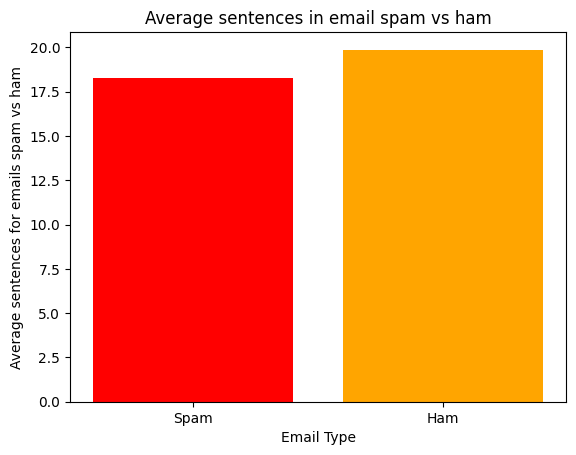

In [12]:
# average sentence of Emails for Spam and Ham
avg_sentence_spam = data[data['spam'] == 1]['num_sentences'].mean()
avg_sentence_ham = data[data['spam'] == 0]['num_sentences'].mean()
print("Average sentences in Spam Email: ", avg_sentence_spam)
print("Average sentences in Ham Email: ", avg_sentence_ham)

# plotting
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Red', 'Orange'])
plt.title('Average sentences in email spam vs ham')
plt.xlabel('Email Type')
plt.ylabel('Average sentences for emails spam vs ham')
plt.show()

Correlation coefficient between email length and spam classification is:  -0.0656855641180886


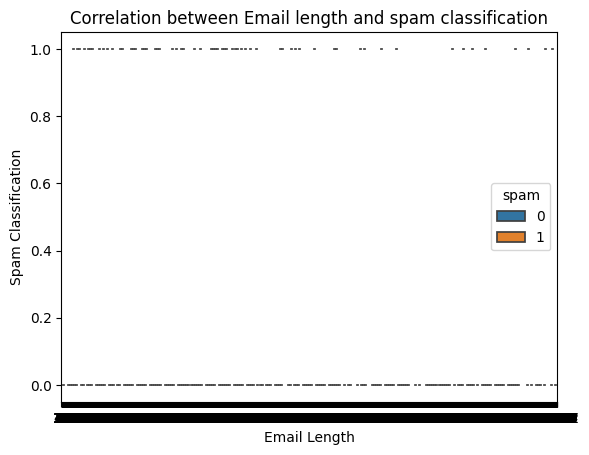

In [13]:
# relationship between length and spam
correlation = data['Length'].corr((data['spam'] == 1))
print('Correlation coefficient between email length and spam classification is: ', correlation)
sns.violinplot(data=data, x='Length', y='spam', hue='spam')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Correlation between Email length and spam classification')
plt.show()

Relationship between features are: 
                  Length  num_words  num_sentences
Length         1.000000   0.986005       0.595949
num_words      0.986005   1.000000       0.660650
num_sentences  0.595949   0.660650       1.000000


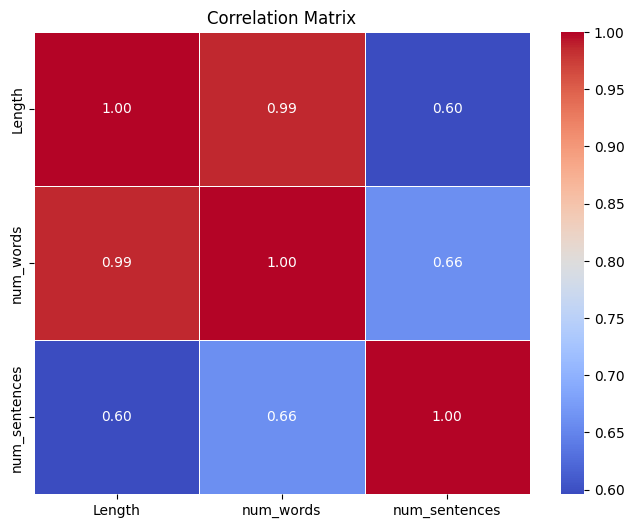

In [14]:
# relationship between features
correlation_mat = data[['Length', 'num_words', 'num_sentences']].corr()
print('Relationship between features are: \n', correlation_mat)

# on a matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [15]:
# data preprocessing
# Steps: change to lower case, remove special chars, delete stopwords and punctuation
data['transform_email'] = data['email'].str.lower() 
data['transform_email'] = data['transform_email'].apply(word_tokenize)
data['transform_email'] = data['transform_email'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])
stop_words = set(stopwords.words('english'))
data['transform_email'] = data['transform_email'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])
# Stemming -> makes data readable for nlp tasks
ps = PorterStemmer()
data['transform_email'] = data['transform_email'].apply(lambda x: [ps.stem(word) for word in x])
# converting back to string
data['transform_email'] = data['transform_email'].apply(lambda x: ' '.join(x))
print(data[['email', 'transform_email']])

                                                  email  \
0     Subject: naturally irresistible your corporate...   
1     Subject: the stock trading gunslinger  fanny i...   
2     Subject: unbelievable new homes made easy  im ...   
3     Subject: 4 color printing special  request add...   
4     Subject: do not have money , get software cds ...   
...                                                 ...   
5723  Subject: re : research and development charges...   
5724  Subject: re : receipts from visit  jim ,  than...   
5725  Subject: re : enron case study update  wow ! a...   
5726  Subject: re : interest  david ,  please , call...   
5727  Subject: news : aurora 5 . 2 update  aurora ve...   

                                        transform_email  
0     subject natur irresist corpor ident lt realli ...  
1     subject stock trade gunsling fanni merril muzo...  
2     subject unbeliev new home made easi im want sh...  
3     subject 4 color print special request addit in...  
4

In [16]:
data.head(5)

,email,spam,Length,num_words,num_sentences,transform_email
0,Subject: naturally irresistible your corporate...,1,1484,325,11,subject natur irresist corpor ident lt realli ...
1,Subject: the stock trading gunslinger fanny i...,1,598,90,1,subject stock trade gunsling fanni merril muzo...
2,Subject: unbelievable new homes made easy im ...,1,448,88,4,subject unbeliev new home made easi im want sh...
3,Subject: 4 color printing special request add...,1,500,99,5,subject 4 color print special request addit in...
4,"Subject: do not have money , get software cds ...",1,235,53,9,subject money get softwar cd softwar compat gr...


Top most common words in spam emails: 
subject: 1577 occurrences
compani: 1065 occurrences
com: 1000 occurrences
1: 952 occurrences
mail: 917 occurrences
busi: 897 occurrences
email: 865 occurrences
inform: 818 occurrences
receiv: 727 occurrences
e: 701 occurrences


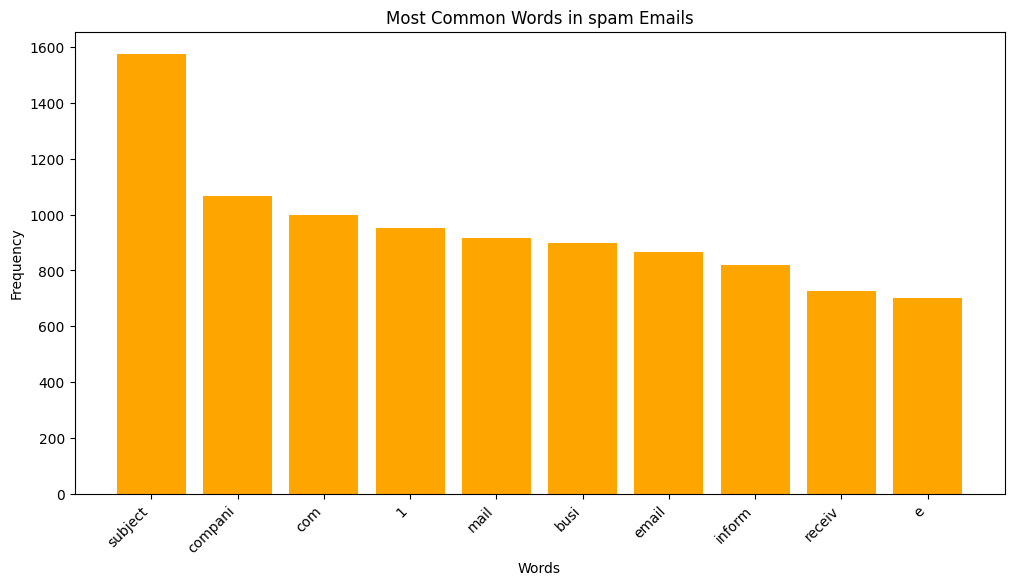

In [17]:
spam_emails = data[data['spam'] == 1]['transform_email']
# tokenizing email text for spam emails
spam_words = ' '.join(spam_emails).split()
# frequency of each word
word_freq = Counter(spam_words)
most_common_words = word_freq.most_common(10)
print("Top most common words in spam emails: ")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
# Plt Bar graph
plt.figure(figsize=(12,6))
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Most Common Words in spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Top 10 most frequent words in ham emails
enron: 13388 occurrence
ect: 11417 occurrence
subject: 8625 occurrence
vinc: 8531 occurrence
hou: 5569 occurrence
2000: 4935 occurrence
kaminski: 4801 occurrence
pleas: 4494 occurrence
com: 4444 occurrence
would: 4151 occurrence


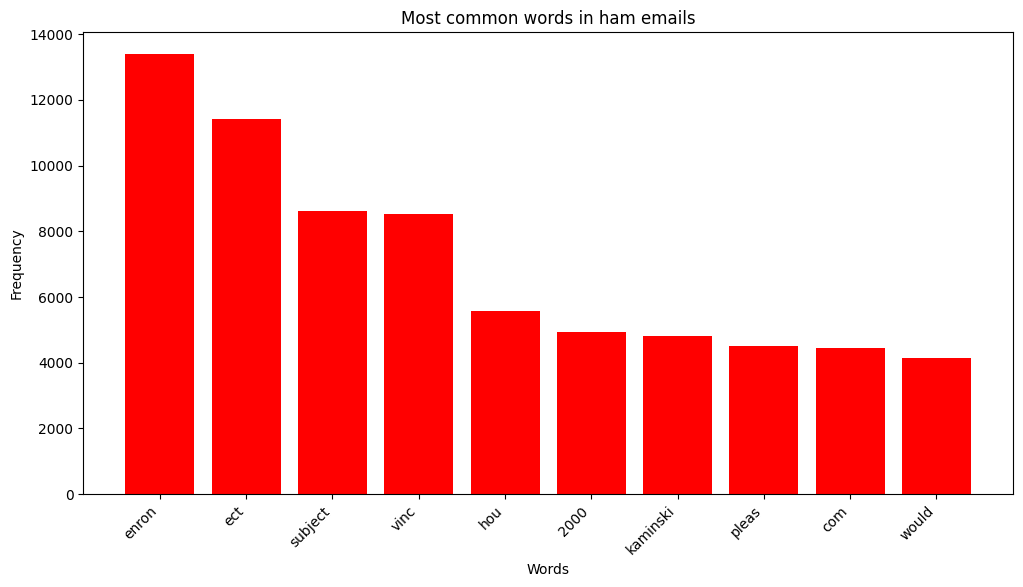

In [18]:
ham_emails = data[data['spam'] == 0]['transform_email']
ham_words = ' '.join(ham_emails).split()
word_freq2 = Counter(ham_words)
most_common_words2 = word_freq2.most_common(10)
print('Top 10 most frequent words in ham emails')
for word, count in most_common_words2:
    print(f'{word}: {count} occurrence')
# plotting
plt.figure(figsize=(12,6))
plt.title('Most common words in ham emails')
words2, counts2 = zip(*most_common_words2)
plt.bar(words2, counts2, color='red')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
# Dividng data into train + test

# vectorizing emails 
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['email']).toarray()
y = data['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# building the model: steps
# use 3 different classifiers to find which is best 
# Support vector mechanisms (SVM)
# Random Forest
# Naive Bayes classifier

In [21]:
# Model 1: Naive Bayes 
nb_class = MultinomialNB()
nb_class.fit(X_train, y_train)
nb_y_pred = nb_class.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")
print("Confusion Matrix: ", confusion_matrix(y_test, nb_y_pred))
print("Precision Score: ", precision_score(y_test, nb_y_pred))

Naive Bayes Accuracy: 0.98
Confusion Matrix:  [[850   6]
 [ 22 268]]
Precision Score:  0.9781021897810219


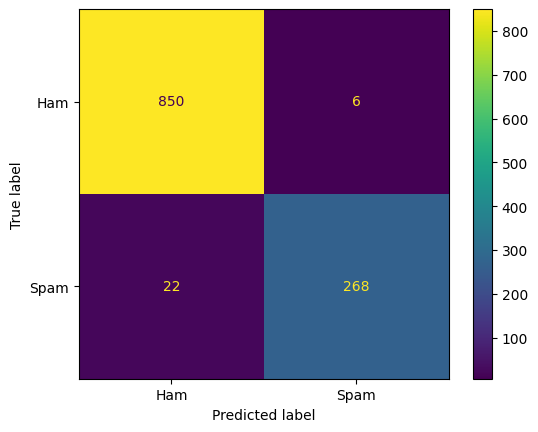

In [22]:
# Plotting Confusion matrix for Naive Bayes Classifier
nb_conf_matrix = metrics.confusion_matrix(y_test, nb_y_pred)
nb_conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix=nb_conf_matrix, display_labels = ['Ham', 'Spam'])
nb_conf_display.plot()
plt.show()

In [23]:
# Model 2: Support Vectors Mechanisms
svc_class = SVC()
svc_class.fit(X_train, y_train)
svc_y_pred = svc_class.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_y_pred)
print(f"SVM Accuracy: {svc_accuracy:.2f}")
print("Confusion Matrix: ", confusion_matrix(y_test, svc_y_pred))
print("Precision Score: "), precision_score(y_test, svc_y_pred)

SVM Accuracy: 0.99
Confusion Matrix:  [[854   2]
 [ 10 280]]
Precision Score: 


(None, 0.9929078014184397)

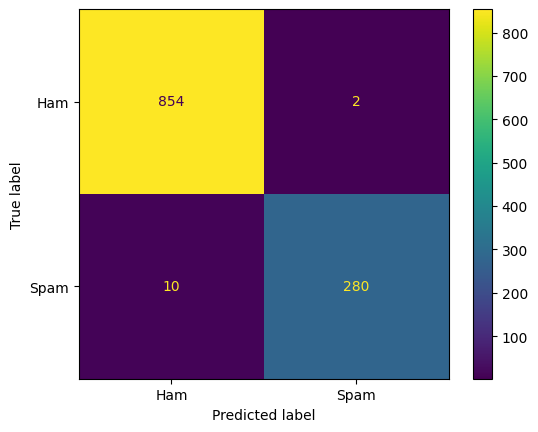

In [24]:
# Plotting Confusion matrix for SVC
svc_conf_matrix = metrics.confusion_matrix(y_test, svc_y_pred)
svc_conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix=svc_conf_matrix, display_labels = ['Ham', 'Spam'])
svc_conf_display.plot()
plt.show()

In [25]:
# Model 3: Random Forest Classifier
rf_class = RandomForestClassifier()
rf_class.fit(X_train, y_train)
rf_y_pred = rf_class.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.2f}")
print("Confusion Matrix: ", confusion_matrix(y_test, rf_y_pred))
print("Precision Score: ", precision_score(y_test, rf_y_pred))

Random Forest Classifier Accuracy: 0.98
Confusion Matrix:  [[856   0]
 [ 25 265]]
Precision Score:  1.0


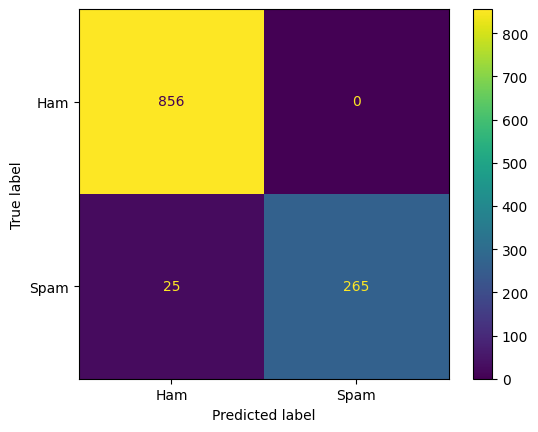

In [26]:
# Plotting Confusion matrix for Naive Bayes Classifier
rf_conf_matrix = metrics.confusion_matrix(y_test, rf_y_pred)
rf_conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix, display_labels = ['Ham', 'Spam'])
rf_conf_display.plot()
plt.show()

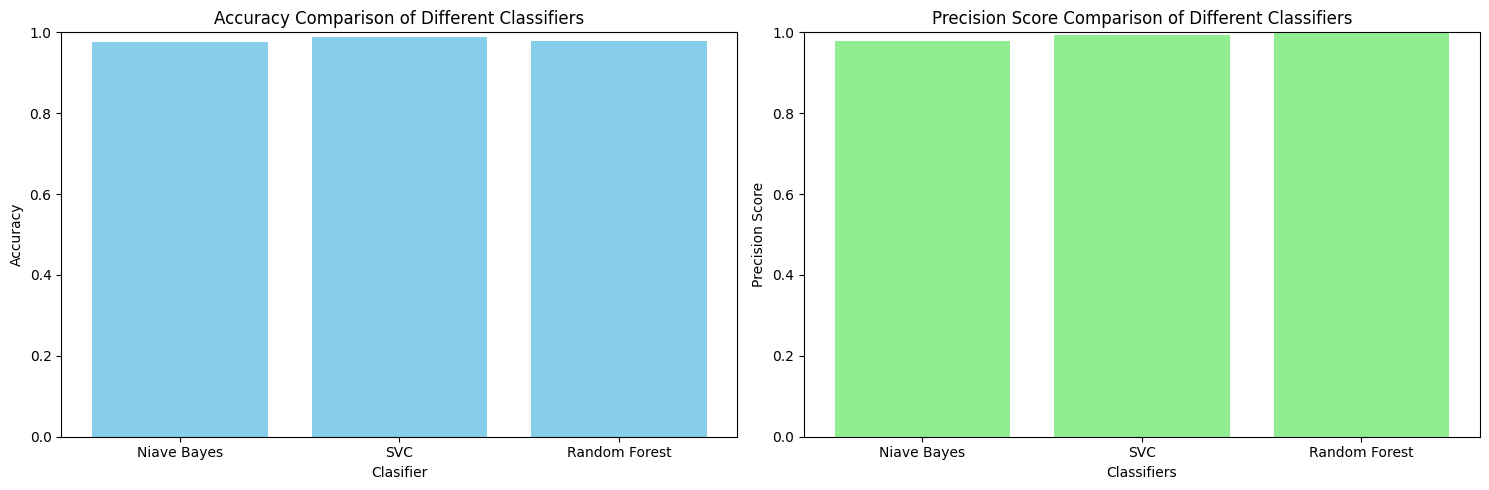

In [31]:
# Choosing the best classifier

# Precision Scores
nb_prec = precision_score(y_test, nb_y_pred)
svc_prec = precision_score(y_test, svc_y_pred)
rf_prec = precision_score(y_test, rf_y_pred)

classifiers = ['Niave Bayes', 'SVC', 'Random Forest']
accuracies = [nb_accuracy, svc_accuracy, rf_accuracy]
prec_scores = [nb_prec, svc_prec, rf_prec]

fig, axes = plt.subplots(1, 2, figsize=(15,5))

# plot graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Clasifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0,1)

# plot graph for precision
axes[1].bar(classifiers, prec_scores, color='lightgreen')
axes[1].set_xlabel('Classifiers')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0,1)
plt.tight_layout()
plt.show()

In [39]:
# Training classifiers on a completely different dataset
new_train_set = pd.read_csv('spam_ham_dataset_train.csv', index_col=0)
new_train_set.head(5)

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [53]:
# Trying SVC Classifier with completely new training set

In [51]:
new_train_emails = new_train_set['text'].values
new_train_labels = new_train_set['label_num'].values

# Converting data into vectors
new_X = tfidf.transform(new_train_emails)
new_X_dense = new_X.toarray()

new_train_pred = svc_class.predict(new_X_dense)

Accuracy of new training data (SVC): 0.9280603364919745
Confusion Matrix of new training data (SVC): [[3572  100]
 [ 272 1227]]
Precision score for new training data (SVC): 0.9246420497362472


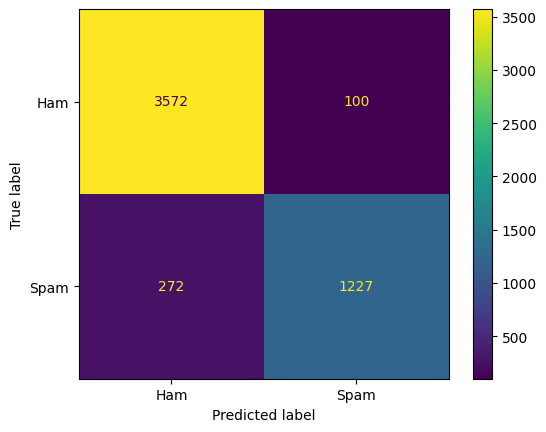

In [55]:
# Looking at result
new_train_accuracy = accuracy_score(new_train_labels, new_train_pred)
new_train_conf_mat = confusion_matrix(new_train_labels, new_train_pred)
new_train_prec = precision_score(new_train_labels, new_train_pred)

print(f"Accuracy of new training data (SVC): {new_train_accuracy}")
print(f"Confusion Matrix of new training data (SVC): {new_train_conf_mat}")
print(f"Precision score for new training data (SVC): {new_train_prec}")

# Drawing confusion matrix
new_train_conf_matrix = metrics.confusion_matrix(new_train_labels, new_train_pred)
new_train_conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix=new_train_conf_matrix, display_labels = ['Ham', 'Spam'])
new_train_conf_display.plot()
plt.show()
